In [2]:
#create figure of silicon 
from ase.build import bulk
from ase.io import read, write
from IPython.display import Image

st_cubic = bulk('Si', 'diamond', a=5.4289, cubic=True)
write('Si_cubic.png', st_cubic * (2, 2, 2), rotation='0z,0x')
Image(filename='Si_cubic.png')

In [3]:
#Create input geometry
st = bulk('Si', 'diamond', a=5.4289) #https://wiki.fysik.dtu.dk/ase/ase/atoms.html
print(st.cell) #Primitive vectors
print(st.positions) # Cartesian positions
print(st.get_scaled_positions()) #reduced positions
print(st.get_cell_lengths_and_angles())
print(st.get_volume())

Cell([[0.0, 2.71445, 2.71445], [2.71445, 0.0, 2.71445], [2.71445, 2.71445, 0.0]])
[[0.       0.       0.      ]
 [1.357225 1.357225 1.357225]]
[[0.   0.   0.  ]
 [0.25 0.25 0.25]]
[ 3.838812  3.838812  3.838812 60.       60.       60.      ]
40.001431634892235


In [3]:
#Save geometry as POSCAR
from ase.io.vasp import write_vasp
write_vasp('sampleinputs/POSCAR_em', st, direct = True, vasp5 = True)

In [5]:
#Read VASP geometry
from ase.io.vasp import read_vasp
st_em = read_vasp('sampleoutputs/CONTCAR_em')
print(st_em.cell)

[[-0.          2.73479515  2.73479515]
 [ 2.73479515  0.          2.73479515]
 [ 2.73479515  2.73479515 -0.        ]]


In [7]:
#Get stress tensor
from siman import header
from siman.classes import CalculationVasp # sudo pip3 install siman
header.show_head = 1
cl = CalculationVasp(output='sampleoutputs/OUTCAR_sp')
cl.name = 'Single point '
cl.read_results()


-- Attention!, No CONTCAR: sampleoutputs/CONTCAR_sp . I use data from outcar 

-- Attention!, SCF was not converged to desirable prec 0.024 > 0 meV 

-- name                          |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    


'Single point |  -10.8298  |3.87, 3.87, 3.87|  -219,-219,-219    |   1,10, 10   '

In [ ]:
#plot phonon density of states using pymatgen and phonopy
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun

from phonopy import Phonopy # install with sudo pip3 install phonopy
from phonopy.structure.atoms import Atoms as PhonopyAtoms
from phonopy.units import VaspToTHz
%matplotlib inline
Si_primitive = PhonopyAtoms(symbols=['Si'] * 2,
                            scaled_positions=[(0, 0, 0), (0.25, 0.25, 0.25)], 
                            cell=[[0.,      2.71445, 2.71445],
                                  [2.71445, 0.,      2.71445],
                                  [2.71445, 2.71445, 0.     ]])

# supercell size
scell = [[1,0,0],[0,1,0],[0,0,1]]

vrun = Vasprun('sampleoutputs/vasprun_freq.xml')

phonon = Phonopy(Si_primitive, scell,factor=VaspToTHz)

# negative sign to ensure consistency with phonopy convention
phonon.set_force_constants(-vrun.force_constants)
mesh = [31, 31, 31]
phonon.set_mesh(mesh)

phonon.set_total_DOS()
phonon.plot_total_DOS().show()

In [4]:
#Equation of State, 
#make cells with different lattice constants
from ase.build import bulk
from ase.io.vasp import write_vasp
import numpy as np

for i, a in enumerate(np.linspace(5,6,7)):
    st = bulk('Si', 'diamond', a=a)
    write_vasp('sampleinputs/POSCAR_eos'+str(i), st, direct = True, vasp5 = True)


B = 87 GPa,  a = 4.34 A


<AxesSubplot:title={'center':'sj: E: -5.415 eV, V: 20.490 Å$^3$, B: 87.434 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

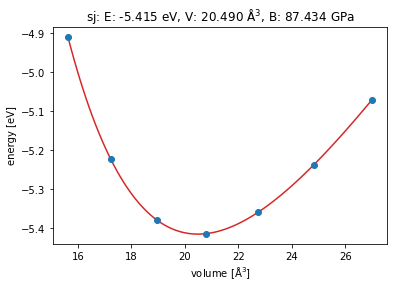

In [6]:
#plot EoS
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState

configs = []
for i, a in enumerate(np.linspace(5,6,7)):
    configs.append(read('sampleoutputs/OUTCAR_eos'+str(i)))  # read 7 configurations
# Extract volumes and energies:
volumes = [ag.get_volume()/2 for ag in configs]
energies = [ag.get_potential_energy()/2 for ag in configs]

eos = EquationOfState(volumes, energies, eos = 'sjeos')
v0, e0, B = eos.fit()
print('B = {:.0f} GPa,  a = {:.2f} A'.format(B / kJ * 1.0e24, (v0*4)**(1/3)))
eos.plot('Si_eos.pdf', )

In [ ]:
#Read elastic tensor
from siman.classes import CalculationVasp # sudo pip3 install siman
cl = CalculationVasp(output='sampleoutputs/OUTCAR_elastic')
cl.read_results()

In [1]:
#Plot band structure with pymatgen
%matplotlib inline
from pymatgen.io.vasp import Vasprun, BSVasprun
from pymatgen.electronic_structure.plotter import BSPlotter

v = BSVasprun("sampleoutputs/vasprun_band.xml")
bs = v.get_band_structure(kpoints_filename="sampleinputs/KPOINTS_band",line_mode=True)
plt = BSPlotter(bs,)
ax = plt.get_plot(vbm_cbm_marker=True, ylim = (-12,6))
ax.savefig('band.pdf')


In [2]:
#Get band structure info
v = Vasprun('sampleoutputs/vasprun_band.xml')
ll = list(v.eigenvalue_band_properties)
print('band gap = {:.1f} eV, cbm = {:.1f} eV, vbm = {:.1f} eV, is_band_gap_direct = {:}'.format(*ll))

band gap = 0.6 eV, cbm = 6.2 eV, vbm = 5.6 eV, is_band_gap_direct = False


/usr/local/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:888: UserWarning: No POTCAR file with matching TITEL fields was found in /Users/dim/Downloads/Lab3_silicon/sampleoutputs
  warnings.warn("No POTCAR file with matching TITEL fields"


In [7]:
#Calculate effective masses

import numpy as np
#1. Determine coordinates of CBM
kp = bs.get_cbm()['kpoint']
print('Reduced coordinates of CBM are', kp.frac_coords) # fractional coordinates of CBM for KPOINTS file
# print(kp.cart_coords) # cartesian coordinates of CBM

#2. Create k-points file with by hands and make calculations, see KPOINTS_mass


#3. Read band structure

v = BSVasprun("sampleoutputs/vasprun_mass.xml")
# bs_mass = v.get_band_structure(kpoints_filename="sampleinputs/KPOINTS_mass",line_mode=False)
bs_mass = v.get_band_structure()



#function for calculating effective mass using three point derivative
def calc_eff_mass(bs, kpoints_indices, band, out_string):
    # band starting from one
    # kpoints from one
    #out_string - string for output, e.g. type of carrier
    
    spin = list(bs.bands.keys())[0] # using spin up
    kis = kpoints_indices

    kp = [bs.kpoints[i-1].cart_coords for i in kis] # 


    en = [bs.bands[spin][band-1][i-1]/27.1 for i in kis] # and convert to Hartree units

    dh_A = np.linalg.norm(kp[1] - kp[0]) #displacement in k-space
    dh = dh_A * 0.529177    #  converted to Bohr-1 units
    
    deriv = (en[2] - 2*en[1] + en[0])/dh**2 # second order derivative with three-point method 
   


    dE = en[2] - en[1]
    m_eff = 1/deriv # effective mass relative to electron mass, since h_bar = 1, m_e = 1 in Hartree units
    print('Effective mass of {:s} = {:5.2f} m_e; band = {:n}, dE = {:5.2f} meV, delta = {:.4f} A^-1'.format(out_string, m_eff, band, dE*1000, dh) )

    
    
#4. Electron effective masses, band No5, KPOINTS 4,5,6 for longitudinal, 7,8,9 for transverse
kpoints_hole = [1,2,3]
kpoints_el_long = [4,5,6]
kpoints_el_tran1 = [7,8,9]
kpoints_el_tran2 = [10,11,12]
calc_eff_mass(bs_mass, kpoints_hole, 2,    'light hole')  #ligth 
calc_eff_mass(bs_mass, kpoints_hole, 3,    'heavy hole')  #heavy
calc_eff_mass(bs_mass, kpoints_hole, 4,    'heavy hole')  #heavy

 
calc_eff_mass(bs_mass, kpoints_el_long, 5, 'long. elec')
calc_eff_mass(bs_mass, kpoints_el_tran1, 5, 'tran1. elec')
calc_eff_mass(bs_mass, kpoints_el_tran2, 5, 'tran2. elec')

Effective mass of light hole = -0.16 m_e; band = 2, dE = -0.47 meV, delta = 0.0122 A^-1
Effective mass of heavy hole = -0.27 m_e; band = 3, dE = -0.28 meV, delta = 0.0122 A^-1
Effective mass of heavy hole = -0.27 m_e; band = 4, dE = -0.28 meV, delta = 0.0122 A^-1
Effective mass of long. elec =  0.95 m_e; band = 5, dE =  0.14 meV, delta = 0.0122 A^-1
Effective mass of tran1. elec =  0.20 m_e; band = 5, dE =  0.37 meV, delta = 0.0122 A^-1
Effective mass of tran2. elec =  0.20 m_e; band = 5, dE =  0.37 meV, delta = 0.0122 A^-1


/usr/local/lib/python3.6/dist-packages/pymatgen/io/vasp/inputs.py:1843: UnknownPotcarWarning:

POTCAR with symbol Si has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_52', 'PBE_54', 'unvie_PBE_52']



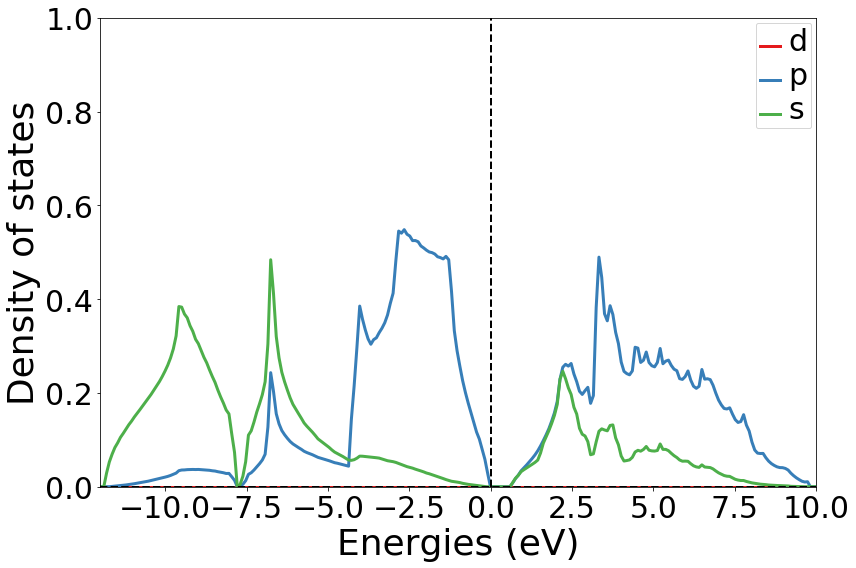

In [5]:
#Plot PDOS with pymatgen
%matplotlib inline
from pymatgen.io.vasp import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter

v = Vasprun('sampleoutputs/vasprun_dos.xml')
cdos = v.complete_dos
spd_dos = cdos.get_spd_dos()
plotter = DosPlotter()
plotter.add_dos_dict(spd_dos)
plotter.show(xlim=[-12, 10], ylim=[0, 1])

/home/aksenov/simanrc.py was read
-- Attention!, No CONTCAR: sampleoutputs/CONTCAR_dos . I use data from outcar 

-- Attention!, SCF was not converged to desirable prec 0.024 > 0 meV 

-- No children were found, using self ('sampleoutputs/OUTCAR_dos', '0', 1) 

-- Attention!, No CONTCAR: sampleoutputs/CONTCAR_dos . I use data from outcar 

-- Attention!, SCF was not converged to desirable prec 0.024 > 0 meV 



Max. F. tot  (meV/A) = 
[0]; 

--                           |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- db['noname']                  |noname|  -10.8303  |3.87, 3.87, 3.87|  -219,-219,-219    |   1,10, 10    
-- I have found  1 non-equivalent positions for Si : dict_keys([0]) 
-- Atom numbers (from zero!):  {0: [0, 1]} 

Choosing  0 atom  0
-- cl1: Atom 1 of type Si is choosen 

-- cl1: Atom numbers: {1: 'Si', 2: 'Si'} 

-- I have found  1 non-equivalent positions for Si : dict_keys([0]) 
-- Atom numbers (from zero!):  {0: [0, 1]} 

-- cl1: [

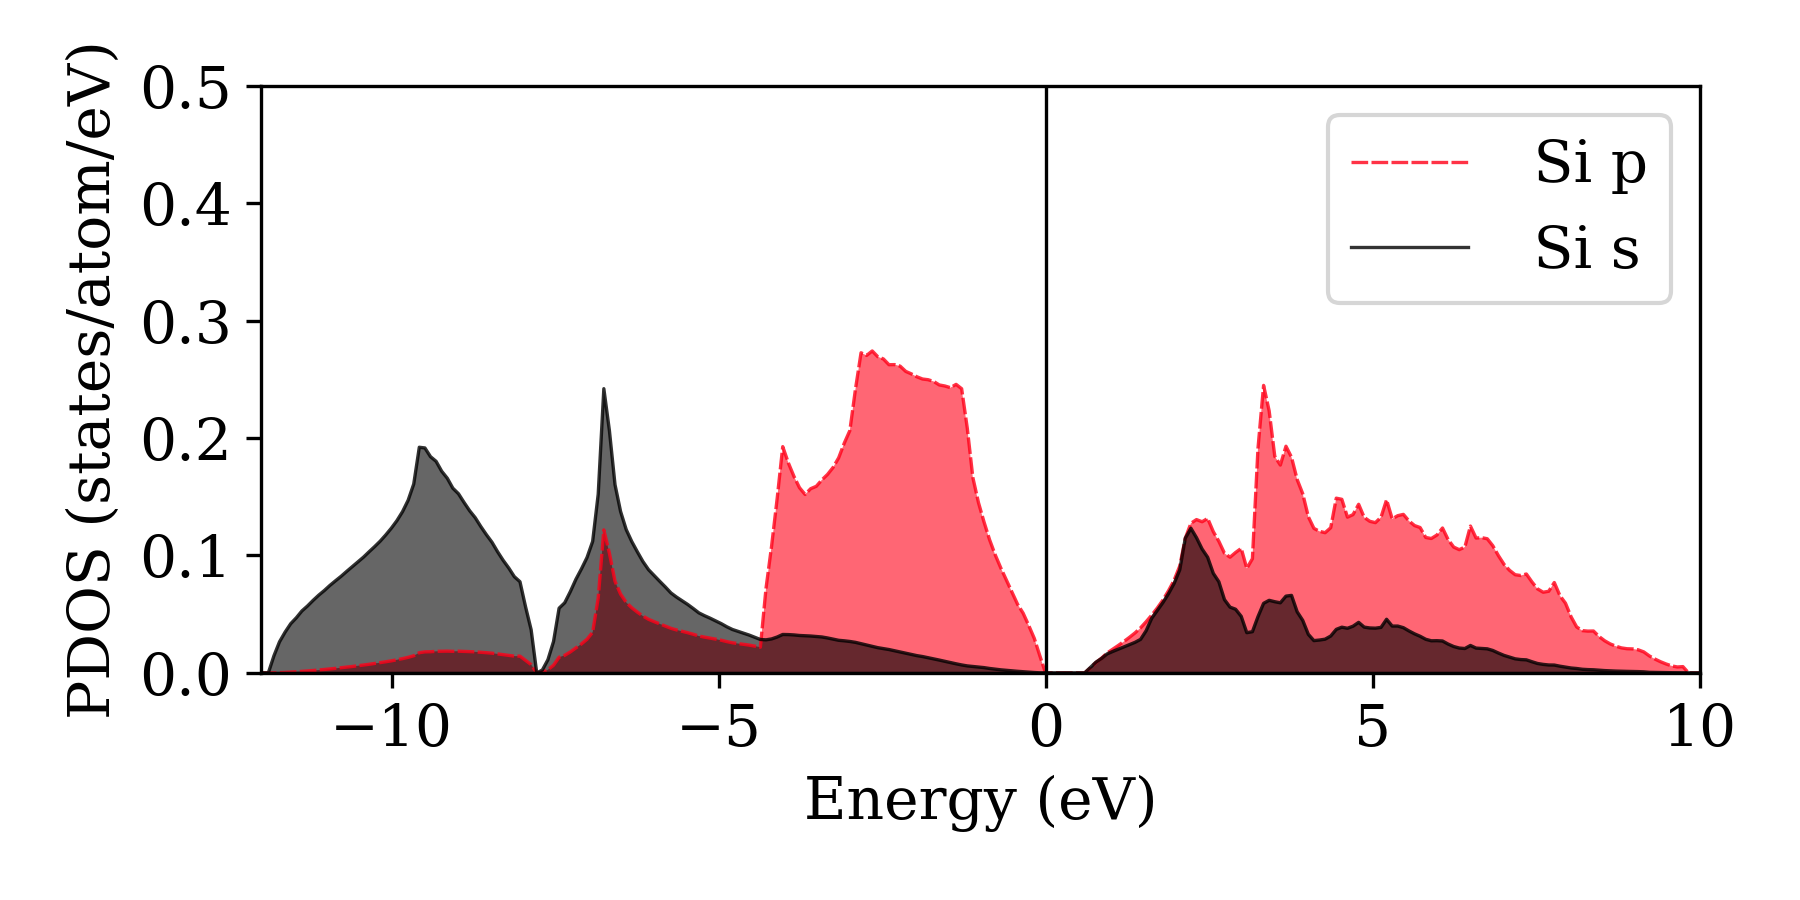

In [6]:
#plot DOS using siman
from IPython.display import Image
from siman.classes import CalculationVasp # sudo pip3 install siman


cl = CalculationVasp(output='sampleoutputs/OUTCAR_dos')
cl.read_results()
cl.dos(0, 'Si', ylim = (0,0.5), xlim = (-12, 10), orbitals = 'sp', fontsize = 14, labels = [''], image_name = 'dos')
Image(filename='png/dos.png')

In [4]:
#show dos image using different approaches
from IPython.display import Image
from IPython.display import IFrame
#from wand.image import Image as WImage # sudo pip3 install wand
# IFrame("dos/sampleoutputs/OUTCAR_dos_at_Si1.sp.Si1.pdf", width=600, height=300)
#WImage(filename='dos/sampleoutputs/OUTCAR_dos_at_Si1.sp.Si1.pdf')
#Image(filename='dos/sampleoutputs/png/OUTCAR_dos_at_Si1.sp.Si1.png')

In [16]:
#cubic cell for charge density
from ase.io import read, write
st = bulk('Si', 'diamond', a=5.47, cubic = True) #https://wiki.fysik.dtu.dk/ase/ase/atoms.html
print(st.cell)
write('sampleinputs/POSCAR_sc', st * (2, 1, 1))

[[5.47 0.   0.  ]
 [0.   5.47 0.  ]
 [0.   0.   5.47]]


In [11]:
# Plot dielectric function
%matplotlib inline
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Vasprun

v = Vasprun('sampleoutputs/vasprun_LOPTICS.xml')
en = v.dielectric[0]
real = v.dielectric[1] 
img = v.dielectric[2]

real = list(map(list, zip(*real)))[0] #only x
img = list(map(list, zip(*img)))[0] #only x
plt.rcParams.update({'font.size': 14})
plt.plot(en, real, label = 'real')
plt.plot(en, img, label = 'imag')
plt.xlim(0, 25)
plt.legend()
plt.xlabel('Energy, eV')
plt.ylabel('$\epsilon$')

# plt.show()
plt.savefig('diel.pdf')
# print(real)


/usr/local/lib/python3.6/dist-packages/pymatgen/io/vasp/inputs.py:1843: UnknownPotcarWarning:

POTCAR with symbol Si has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'unvie_PBE_52', 'PBE_52']

